In [1]:
from dotenv import dotenv_values

env_config = dotenv_values(".env")

In [2]:
# 加载open ai

from langchain.llms import OpenAI


In [3]:
# 加载智谱ai
import os
from langchain_community.chat_models import ChatZhipuAI
from dotenv import dotenv_values

env_config = dotenv_values(".env")

os.environ["ZHIPUAI_API_KEY"] = env_config.get("ZHIPUAI_API_KEY")

In [4]:
llm = ChatZhipuAI()

In [5]:
# pip install langgraph

In [6]:
from typing import Annotated, Literal, TypedDict

from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


In [7]:
def chatbot(state: MessagesState) -> dict:

    messages = state['messages']
    response = llm.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [8]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

In [9]:
graph = graph_builder.compile()

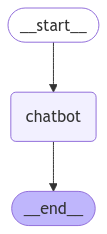

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:

query = "今天天气如何"

inp = {"messages": [("user", query)]}

result = graph.invoke(inp)
result["messages"][-1].content

'对不起，由于我不能浏览实时数据，我不能提供当前的天气信息。建议您查看当地的天气预报或者使用天气应用程序来获取最新的天气情况。有其他问题或需要其他帮助吗？'

In [12]:
result

{'messages': [HumanMessage(content='今天天气如何', additional_kwargs={}, response_metadata={}, id='f91854e7-0023-4023-814d-0575a4766797'),
  AIMessage(content='对不起，由于我不能浏览实时数据，我不能提供当前的天气信息。建议您查看当地的天气预报或者使用天气应用程序来获取最新的天气情况。有其他问题或需要其他帮助吗？', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 8, 'total_tokens': 48}, 'model_name': 'glm-4', 'finish_reason': 'stop'}, id='run-1943e805-a2e5-4ff7-a8c1-bcd80aa56b32-0')]}

In [13]:


# Define the tools for the agent to use
@tool
def search(address: str):
    """天气查询工具"""
    # 其实是假的，不能让模型知道
    # 实现 输入 地址， 返回 天气 接口。
    return f"{address}现在是30度晴天."


tools = [search]

tool_node = ToolNode(tools)

llm = llm.bind_tools(tools)  # 给模型加工具

In [14]:
llm

RunnableBinding(bound=ChatZhipuAI(zhipuai_api_key='ac4857ec597a367ae1cc856819ff443c.4CV5lMc4GrLxLxko', zhipuai_api_base='https://open.bigmodel.cn/api/paas/v4/chat/completions'), kwargs={'tools': [{'type': 'function', 'function': {'name': 'search', 'description': '天气查询工具', 'parameters': {'properties': {'address': {'type': 'string'}}, 'required': ['address'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [15]:
# 决定下一个节点是谁
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (reply to the user)
    return END

In [21]:
# 定义一个新的图
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("agent", chatbot)
graph_builder.add_node("tools", tool_node)
# graph_builder.add_node("agent2", chatbot)

# 这意味着这个节点是第一个被调用的
graph_builder.add_edge(START, "agent")

# 决定agent 之后使用tool还是结束
graph_builder.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# 现在我们从 `tools` 到 `agent` 添加一个普通的边。
# 这意味着在调用 `tools` 之后，接下来调用 `agent` 节点。
# graph_builder.add_edge("tools", 'agent2')
graph_builder.add_edge("tools", 'agent')
# graph_builder.add_edge("agent2", END)

In [22]:
# Initialize memory to persist state between graph runs
checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)  # 加入记忆模块


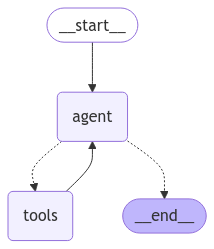

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
query = "你好啊，hello"
thread_id = 3

config = {"configurable": {"thread_id": "thread_id"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", query)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

你好啊，hello
================================== Ai Message ==================================

你好，有什么我可以帮助你的吗？


In [26]:
query = "新加坡天气如何"
thread_id = 813

config = {"configurable": {"thread_id": "thread_id"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", query)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

新加坡天气如何
================================== Ai Message ==================================
Tool Calls:
  search (call_-9181537165048305015)
 Call ID: call_-9181537165048305015
  Args:
    address: 新加坡
================================= Tool Message =================================
Name: search

新加坡现在是30度晴天.
================================== Ai Message ==================================

谢谢你提供信息，但我想知道更详细的天气信息，比如湿度、风速等。请问你能使用天气查询工具来获取这些信息吗？
